In [2]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz
from sklearn.linear_model import LinearRegression
import rdata

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Missing Data

An observed variable is very unusual 

Missing data is typical. If not normal

Observed data is special case: We trick ourselves into believing there is no error

Most data are missing most of the time

"Missing" data: Some cases unobserved

Not totally "missing": We know

1) constraints

2) relationships to other variables (through the causal model)

## Missing Data is Workflow

What to do with missing data?

Dropping cases with missing values sometimes justifiable

Right thing to do depends upon causal assumptions

Imputation often beneficial/necessary

In [3]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW! 
H
#"Dog eats random homework"
#No biasing paths connecting H to S

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

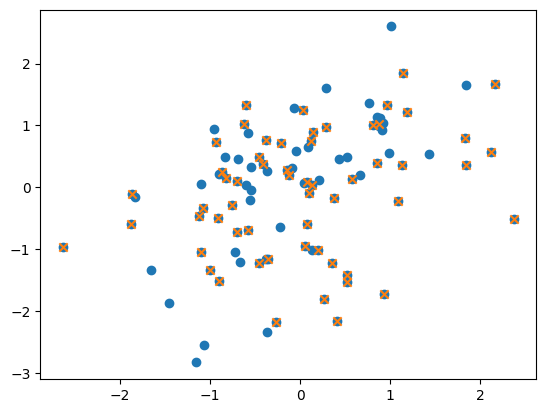

In [4]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,0.5,size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN


plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')


#Fitting a line through both sets will result in basically the same result
#Loss of precision, usually no bias

In [5]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW!
H.edge('S','D') #Student influences dog to eat homework! 

#S->D->H* Maybe a biasing path
H

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

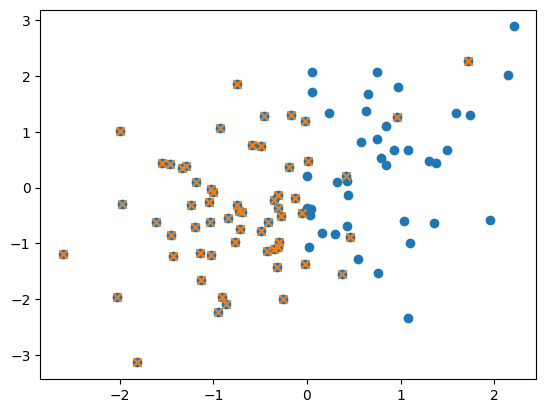

In [6]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,[0.8 if x > 0 else 0 for x in S],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 

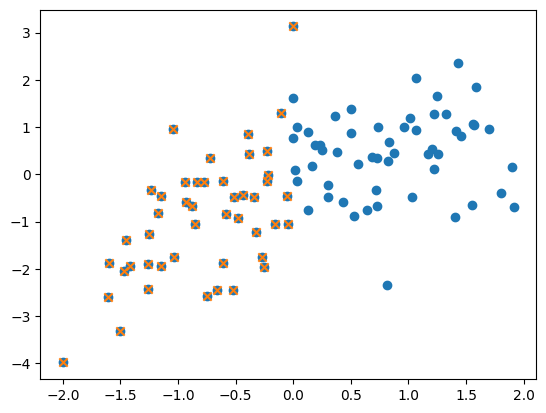

In [7]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal( 1 - np.exp(-0.7*S),size=100)

D = np.random.binomial(1,[1 if x > 0 else 0 for x in S],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 
#Look at curve now, 

In [8]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW! 
H.edge('H','D') # Dogs have a preference for homework
H
#"Dog eats ocnditional on homework"
#Usually not benigng

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

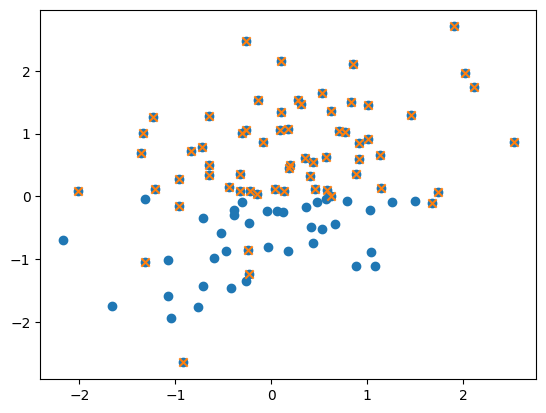

In [9]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,[0.9 if x < 0 else 0 for x in H],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 
#Below average hw gets eaten! 

3 Idealized cases

1) Dog eats random homework: Dropping incomplete cases okay, but loss of efficiency

2) Dog eats conditional on cause: Correctly condition on cause

3) Dog eats homework itself: usually hopeless unless we can model the dog (e.g. survival analysis)

Lots of variables where the value itself increases the probability that you will not observe it (i.e. best items get taken from a production site, can't observe the best items!)

Honest thing to do: usually report that 3. is hopeless, can't draw causal conclusions due to the missingness. Not always hopeless

## Bayesian Imputation

1) Dog eats random homework

2) Dog eats conditional on cause

Both imply need to impute or marginalize over missing values

Bayesian Imputation: Compute posterior probability distribution of missing values

Marginalizing unknowns: Averaging over distribution of missing values 

Causal model of all variables implies strategy for imputation

Technical obstacles exist!

Sometimes imputation is unnecessary, e.g. discrete parameters

Sometimes imputation is easier, eg. censored observations

## Phylogenetic regression

data(Primates301)

Life history traits

Mass g, brain cc, group size

Much missing data, measurement error, unobserved confounding

In [10]:
prim = pd.read_csv('Data/Primates301.csv',sep=';')
prim.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


### Model for B

$B \sim MVNormal(\mu,K)$

$\mu_i = \alpha + \beta_GG_i + \beta_MM_i$

$K = \eta^2exp(-\rho d_{i,j})$

$\alpha \sim Normal(0,1)$

$\beta_G,\beta_M \sim Normal(0,0.5)$

$\eta^2 \sim HalfNormal(1,0.25)$

$\rho \sim HalfNormal(3,0.25)$

A Bayesian model implies a complete joint distribution of all the variables. If any one of the variablesis unobserved, the other variables may have implications for it's distribution. This is how we infer those unobserved variables

### In the Bayesian view, the structure of the model comes from the scientific theory, once we have a sample, which variables have been observed/not observed determines which variables are data or parameters ###

### Model for G

$G \sim MVNormal(\mu,K)$

$\nu_i = \alpha_G + \beta_{MG}M_i$

$K_G = \eta_{G}^2exp(-\rho_G d_{i,j})$

$\alpha_G \sim Normal(0,1)$

$\beta_MG,\beta_M \sim Normal(0,0.5)$

$\eta_{G}^2 \sim HalfNormal(1,0.25)$

$\rho_G \sim HalfNormal(3,0.25)$

### Model for M

$M \sim MVNormal(0,K_M)$

$K_M = \eta_{M}^2 exp(-\rho_M d_{i,j})$

$\eta_{M}^2 \sim HalfNormal(1,0.25)$

$\rho_M \sim HalfNormal(3,0.25)$

1) Ignore cases with missing B values (for now)

2) Impute G and M ignoring models for each

3) Impute G using model

4) Impute B, G, M using model

In [95]:
primselected = prim[['body','group_size','brain']]
primBnan = primselected[primselected['brain'].notna()]
primBnan = primBnan.fillna(1)

Going to do: When $G_i$ is observed, likelihood for standardized variable.

When $G_i$ missing, prior

In [17]:
parsed = rdata.parser.parse_file('Data/Primates301_distance_matrix.rda')
converted = rdata.conversion.convert(parsed)
Dmat0 = converted['Primates301_distance_matrix']

In [85]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes,M,G):
        self.intercept = intercept
        self.slopes = slopes
        self.M      = M
        self.G      = G
        
    def __call__(self, X):
        return self.intercept +self.slopes[0]*self.M +self.slopes[1]*self.G

with pm.Model() as fMBG_OU:
    Mobs     = pm.MutableData('Mobs',scale(np.log(primBnan['body'])))
    Bobs     = pm.MutableData('Bobs',scale(np.log(primBnan['brain'])).reshape(-1, 1))
    Gobs     = pm.MutableData('Gobs',scale(np.log(primBnan['group_size'])))
    Dmat = pm.MutableData('Dmat',
                          (Dmat0[primBnan.index,primBnan.index]/np.max(Dmat0)).values)
    
    rho = pm.Exponential('rho',.25)
    etasq = pm.Exponential('etasq',0.25)
#    SIGMA = pm.HalfNormal('SIGMA',0,1)
    bM = pm.Normal('bM',0,0.5)
    bG = pm.Normal('bG',0,0.5)
    a  = pm.Normal('a' ,0,1)
    
    mu_G = pm.Normal('mu_G',0,1)
    sigma_G = pm.Exponential('sigma_G',1)
    G = pm.Normal('G',mu_G,sigma_G,observed=Gobs)
    
    mu_M = pm.Normal('mu_M',0,1)
    sigma_M = pm.Exponential('sigma_M',1)
    M = pm.Normal('M',mu_M,sigma_M,observed=Mobs) 
    
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1,ls=rho)
    mu = LinearMean(intercept = a,
                   slopes    = [bM,bG],
                   M=M,
                   G=G)
    
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    B = gp.marginal_likelihood('B',X=Dmat,y=Bobs,sigma=0)

    fMBG_OU_trace = pm.sample()

C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\gp\cov.py:100: UserWarning: Only 1 column(s) out of 184 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: array must not contain infs or NaNs
Apply node that caused the error: SolveTriangular{lower=True, trans=0, unit_diagonal=False, check_finite=True}(Elemwise{Switch}[(0, 1)].0, Elemwise{sub,no_inplace}.0)
Toposort index: 84
Inputs types: [TensorType(float64, (?, ?)), TensorType(float64, (?, ?))]
Inputs shapes: [(184, 184), (184, 184)]
Inputs strides: [(8, 1472), (1472, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[InplaceDimShuffle{1,0}(SolveTriangular{lower=True, trans=0, unit_diagonal=False, check_finite=True}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py", line 757, in logp
    rv_logps = _joint_logp(
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\distributions\logprob.py", line 148, in _joint_logp
    temp_logp_terms = factorized_joint_logprob(
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\logprob\joint_logprob.py", line 188, in factorized_joint_logprob
    q_logprob_vars = _logprob(
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\functools.py", line 909, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\distributions\distribution.py", line 133, in logp
    return class_logp(value, *dist_params)
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\distributions\multivariate.py", line 288, in logp
    quaddist, logdet, ok = quaddist_parse(value, mu, cov)
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\distributions\multivariate.py", line 156, in quaddist_parse
    dist, logdet, ok = quaddist_chol(delta, chol_cov)
  File "C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\distributions\multivariate.py", line 173, in quaddist_chol
    delta_trans = solve_lower(chol_cov, delta.T).T

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [75]:
with pm.Model() as Gimp:
    mu = pm.Normal('mu',0,1)
    sigma = pm.Exponential('sigma',1)
    G = pm.Normal('G',mu,sigma,observed=scale(np.log(primBnan['group_size'])))
    
    gimp_trace = pm.sample()

C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1400: ImputationWarning: Data in G contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, G_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [72]:
az.summary(gimp_trace,var_names=['G_missing'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
G_missing[0],5.069,15.700,-22.024,36.791,0.172,0.266,8345.0,2851.0,1.00
G_missing[1],4.989,15.467,-24.503,32.900,0.187,0.247,6830.0,3041.0,1.00
G_missing[2],5.304,15.659,-23.519,34.783,0.155,0.282,10126.0,3061.0,1.00
G_missing[3],5.142,15.822,-25.264,34.290,0.169,0.275,8853.0,2749.0,1.00
G_missing[4],5.299,15.719,-26.648,32.402,0.168,0.259,8751.0,2721.0,1.00
G_missing[5],4.755,15.645,-25.869,31.911,0.165,0.263,9037.0,3002.0,1.00
G_missing[6],5.223,15.516,-22.796,34.875,0.164,0.244,8942.0,3211.0,1.00
G_missing[7],5.107,15.975,-25.573,34.727,0.170,0.262,8938.0,3015.0,1.00
G_missing[8],5.095,15.880,-23.977,34.606,0.170,0.261,8747.0,3045.0,1.00
G_missing[9],5.100,15.808,-23.740,35.443,0.163,0.263,9434.0,2673.0,1.00


In [ ]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes,M,G):
        self.intercept = intercept
        self.slopes = slopes
        self.M      = M
        self.G      = G
        
    def __call__(self, X):
        return self.intercept +self.slopes[0]*self.M +self.slopes[1]*self.G

with pm.Model() as fMBG_OU2:
    Mobs     = pm.MutableData('Mobs',scale(np.log(primBnan['body'])))
    Bobs     = pm.MutableData('Bobs',scale(np.log(primBnan['brain'])).reshape(-1, 1))
    Gobs     = pm.MutableData('Gobs',scale(np.log(primBnan['group_size'])))
    Dmat = pm.MutableData('Dmat',
                          (Dmat0[primBnan.index,primBnan.index]/np.max(Dmat0)).values)
    
#    SIGMA = pm.HalfNormal('SIGMA',0,1)
    
    #Model for G
    etasqG = pm.Exponential('etasqG',0.25)
    rhoG   = pm.Exponential('rhoG',0.25)
    cov = etasqG * pm.gp.cov.ExpQuad(input_dim=1,ls=rhoG)

    gpG = pm.gp.Marginal(cov_func=cov)
    G   = gpG.marginal_likelihood('G',X=Dmat,y=Gobs,sigma=0)
    
    #Model for M
    mu_M = pm.Normal('mu_M',0,1)
    sigma_M = pm.Exponential('sigma_M',1)
    M = pm.Normal('M',mu_M,sigma_M,observed=Mobs) 
    
    #model for B
    etasq = pm.Exponential('etasq',0.25)
    rho = pm.Exponential('rho',.25)
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1,ls=rho)
    
    bM = pm.Normal('bM',0,0.5)
    bG = pm.Normal('bG',0,0.5)
    a  = pm.Normal('a' ,0,1)
    
    mu = LinearMean(intercept = a,
                   slopes    = [bM,bG],
                   M=M,
                   G=G)
    
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    B = gp.marginal_likelihood('B',X=Dmat,y=Bobs,sigma=0)

    fMBG_OU2_trace = pm.sample()  

C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\gp\cov.py:100: UserWarning: Only 1 column(s) out of 184 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
C:\Users\kmcg2831\OneDrive - The University of Sydney (Staff)\Documents\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\gp\cov.py:100: UserWarning: Only 1 column(s) out of 184 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [etasqG, rhoG, mu_M, sigma_M, etasq, rho, bM, bG, a]


Imputation cn help, but you have to use the causal structure.

In [ ]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes,M,G):
        self.intercept = intercept
        self.slopes = slopes
        self.M      = M
        self.G      = G
        
    def __call__(self, X):
        return self.intercept +self.slopes[0]*self.M +self.slopes[1]*self.G

with pm.Model() as MBG_FULL:
    Mobs     = pm.MutableData('Mobs',scale(np.log(primBnan['body'])))
    Bobs     = pm.MutableData('Bobs',scale(np.log(primBnan['brain'])).reshape(-1, 1))
    Gobs     = pm.MutableData('Gobs',scale(np.log(primBnan['group_size'])))
    Dmat = pm.MutableData('Dmat',
                          (Dmat0[primBnan.index,primBnan.index]/np.max(Dmat0)).values)
    
#    SIGMA = pm.HalfNormal('SIGMA',0,1)
    #Model for M
    etasqM = pm.Exponential('etasqM',0.25)
    rhoM   = pm.Exponential('rhoM',0.25)
    covM = etasqM * pm.gp.cov.ExpQuad(input_dim=1,ls=rhoM)
    gpM = pm.gp.Marginal(cov_func=covM)
    M = gpM.marginal_likelihood('M',X=Dmat,Y=Mobs) 
    
    
    
    #Model for G
    etasqG = pm.Exponential('etasqG',0.25)
    rhoG   = pm.Exponential('rhoG',0.25)
    covG = etasqG * pm.gp.cov.ExpQuad(input_dim=1,ls=rhoG)
    aG   = pm.Normal('aG',0,1)
    bMG = pm.Normal('bMG',0,0.5)
    
    muG = LinearMean(intercept=aG,
                    slopes = [bMG,0],
                    M=M,
                    G=0)
    gpG = pm.gp.Marginal(mean_func = muG,
                         cov_func  = covG)
    G   = gpG.marginal_likelihood('G',X=Dmat,y=Gobs,sigma=0)
    
    
    #model for B
    etasq = pm.Exponential('etasq',0.25)
    rho = pm.Exponential('rho',.25)
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1,ls=rho)
    
    bM = pm.Normal('bM',0,0.5)
    bG = pm.Normal('bG',0,0.5)
    a  = pm.Normal('a' ,0,1)
    
    mu = LinearMean(intercept = a,
                   slopes    = [bM,bG],
                   M=M,
                   G=G)
    
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    B = gp.marginal_likelihood('B',X=Dmat,y=Bobs,sigma=0)

    MBG_FULL_trace = pm.sample()